# Titanic baseline models
### Prediction of survival rate using 9 variables

For this analysis we use the <b>Titanic Kaggle Competition</b> dataset found on the Kaggle Data
Repository at the following location:

<a href=https://www.kaggle.com/c/titanic/data>Titanic Kaggle Competition Dataset</a>

The objective of the analysis is to classify survivors of the Titanic disaster of 1912 according to
survival.

We aim to achieve this by following the ML pipeline approach of deploying a variety of ML techniques
to build a final predictive model. This particular analysis comprises 4 notebooks as follows:

 1. <i>titanic_baseline</i> - <b>This notebook</b>, baseline predictive models (quick and dirty) to
 compare later results against
 2. <i>titanic_eda</i> - Exploratory Descriptive Analysis (EDA)
 3. <i>titanic_features</i> - Perform feature engineering
 4. <i>titanic_final_model</i> - Final model

We hope to gain valuable insights by following this process. The various steps in the process can be
elaborated on as follows (the various notebooks will focus on different parts of the process as
indicated):

- Load data (<i>all notebooks</i>)
- Prepare data
    - Clean data (<i>notebook 2</i>)
        - Missing values
        - Outliers
        - Erroneous values
    - Explore data (<i>notebook 2</i>)
        - Exploratory descriptive analysis (EDA)
        - Correlation analysis
        - Variable cluster analysis
    - Transform Data (<i>notebook 3</i>)
        - Engineer features
        - Encode data
        - Scale & normalise data
        - Impute data (if not done in previous steps)
        - Feature selection/ importance analysis
- Build model (<i>notebooks 1 & 4</i>)
    - Model selection
    - Data sampling (validation strategy, imbalanced classification)
    - Hyperparameter optimisation
- Validate model (<i>notebooks 1 & 4</i>)
    - Accuracy testing
- Analysis of results (<i>notebook 1 & 4</i>)
    - Response curves
    - Accuracy analysis
    - Commentary

The data dictionary for this dataset is as follows:

| Variable | Definition | Key |
|----------|------------|-----|
| survival | Survival	| 0 = No, 1 = Yes |
| pclass   | Ticket class |	1 = 1st, 2 = 2nd, 3 = 3rd |
|sex | Sex | male, female |
|Age | Age in years | Continuous |
|sibsp | # of siblings / spouses aboard the Titanic | 0, 1, 2, ..|
|parch | # of parents / children aboard the Titanic | 0, 1, 2 ..|
|ticket | Ticket number | PC 17599, STON/O2. 3101282, 330877 |
|fare | Passenger fare | Continuous |
|cabin | Cabin number | C123, C85, E46 |
|embarked | Port of Embarkation	| C = Cherbourg, Q = Queenstown, S = Southampton |

Let us start the analysis for <b>notebook 1</b>!

Our approach for this notebook will be to take shortcuts i.e. drop variables that require
pre-processing, e.g. unstructured text, or where replacement of missing values is required, without
any thought to the best strategy. We will not do any feature engineering or attempt to understand
the data (we will do this in the next notebook). We will rapidly build 4 models to get an idea of the
strength of the signal in the data as well as where there might be issues with the data, or obvious
areas for improvement for the model. The models we will build are the following:

 1. Logistic regression: Bread and butter classification model - Aim is to obtain an idea of how a
 classical linear model performs
 2. Multi-layer Perceptron (MLP): Understand how a simple non-linear model performs
 3. Decision Tree: Provide visual analysis of variable importance and strength of association
 4. Random Forest: Use model that good at dealing with unprocessed categorical variables in order to
 ascertain potential gains of pre-processing in next steps

We will use the scikit-learn libraries to build the prototype models from first principles. In later
notebooks we will use Keras and PyTorch to build the final models.

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from src.visualization.visualize_titanic import plot_confusion_matrix, plot_roc_curve, \
    plot_feature_importance, plot_feature_importance_log, plot_feature_importance_dec, plotVar, \
    plotAge, plotContinuous, plotCategorical
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

<div class="alert alert-block alert-info">
<b>Load data</b>
</div>

In [2]:
# Import data
df_train = pd.read_csv('../data/external/train.csv', header = None, names = ['passenger_id',
                                                                             'survived', 'p_class',
                                                                             'name', 'sex', 'age',
                                                                             'sib_sp', 'parch',
                                                                             'ticket', 'fare',
                                                                             'cabin', 'embarked'],
                       index_col=False, usecols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], skiprows=1,
                       sep=',', skipinitialspace=True)

#### Train Data

In [3]:
df_train.head(20)
print(df_train.shape)


,passenger_id,survived,p_class,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


(891, 12)


In [4]:
# Import data
df_test = pd.read_csv('../data/external/test.csv', header = None, names = ['passenger_id', 'p_class',
                                                                           'name', 'sex', 'age',
                                                                           'sib_sp', 'parch',
                                                                           'ticket', 'fare', 'cabin',
                                                                           'embarked'],
                      index_col=False, usecols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], skiprows=1,
                      sep=',', skipinitialspace=True)

#### Test Data

In [5]:
df_test.head(20)
print(df_test.shape)
df_orig = df_test.copy()

,passenger_id,p_class,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


(418, 11)


The first thing to note is that the dataset read from csv file has 891 rows and 12 data columns. This
is different to the Kaggle data dictionary claiming 891 rows and 10 data columns.

The two extra fields are name and ticket. These unstructured text variables will require
pre-processing and hence I leave them out for the moment. We will also leave cabin out, as it requires
pre-processing too. Excluding the dependent variable we therefore have 9 feature variables for this
analysis.

Let us do minimal exploration of the data and then start building our baseline models!

<div class="alert alert-block alert-info">
<b>Basic data cleaning</b>
</div>

In [6]:
# Create first stab at an improvement, start with the obvious variables to create a quick model. Leave
# ticket out for now, as some parsing will be necessary
df_train = df_train.loc[:, ['survived', 'p_class', 'sex', 'age', 'sib_sp', 'parch', 'fare', 'embarked']]

In [7]:
df_test = df_test.loc[:, ['p_class', 'sex', 'age', 'sib_sp', 'parch', 'fare', 'embarked']]

In [8]:
# Type of data
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   p_class   891 non-null    int64  
 2   sex       891 non-null    object 
 3   age       714 non-null    float64
 4   sib_sp    891 non-null    int64  
 5   parch     891 non-null    int64  
 6   fare      891 non-null    float64
 7   embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [9]:
# Type of data
df_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   p_class   418 non-null    int64  
 1   sex       418 non-null    object 
 2   age       332 non-null    float64
 3   sib_sp    418 non-null    int64  
 4   parch     418 non-null    int64  
 5   fare      417 non-null    float64
 6   embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 23.0+ KB


From the high level checks we can see that there are missing values in the following fields: age, fare
and embarked.

We will impute these values with simple measures of centrality for these variables (median, mode) at
present. During the next stage of the analysis we will revisit this decision by performing EDA before
removing missing values in order to make a more informed decision, for now we forge ahead!

In [10]:
# Check for null values
df_train.isnull().sum()

# Actual null values
df_train[df_train.isnull().any(axis=1)]

survived      0
p_class       0
sex           0
age         177
sib_sp        0
parch         0
fare          0
embarked      2
dtype: int64

,survived,p_class,sex,age,sib_sp,parch,fare,embarked
5,0,3,male,NaN,0,0,8.4583,Q
17,1,2,male,NaN,0,0,13.0000,S
19,1,3,female,NaN,0,0,7.2250,C
26,0,3,male,NaN,0,0,7.2250,C
28,1,3,female,NaN,0,0,7.8792,Q
...,...,...,...,...,...,...,...,...
859,0,3,male,NaN,0,0,7.2292,C
863,0,3,female,NaN,8,2,69.5500,S
868,0,3,male,NaN,0,0,9.5000,S
878,0,3,male,NaN,0,0,7.8958,S


In [11]:
# Check for null values for test data
print(df_test.isnull().sum())
# Actual null values
df_test[df_test.isnull().any(axis=1)]

p_class      0
sex          0
age         86
sib_sp       0
parch        0
fare         1
embarked     0
dtype: int64


,p_class,sex,age,sib_sp,parch,fare,embarked
10,3,male,NaN,0,0,7.8958,S
22,1,female,NaN,0,0,31.6833,S
29,3,male,NaN,2,0,21.6792,C
33,3,female,NaN,1,2,23.4500,S
36,3,female,NaN,0,0,8.0500,S
...,...,...,...,...,...,...,...
408,3,female,NaN,0,0,7.7208,Q
410,3,female,NaN,0,0,7.7500,Q
413,3,male,NaN,0,0,8.0500,S
416,3,male,NaN,0,0,8.0500,S


We observed 177 null values for <i>age</i> and 2 for <i>embarked</i> for <i>training data</i> and 86
null values for <i>age</i> and 1 for <i>fare</i> for <i>testing data</i>.

We will substitute missing values for age with the median values to allow for skewness or outliers in
the distribution as it is a robust measure for central tendency. For embarked we will use the mode
seeing as it is a categorical variable with few classes.

In [12]:
# Replace missing values for training set
df_train = df_train.copy()
median = df_train['age'].median()
df_train['age'].fillna(median, inplace=True)
print("Number of null values in age column: {}".format(df_train['age'].isnull().sum()))

mode = df_train['embarked'].mode()
df_train['embarked'].fillna(mode.iloc[0], inplace=True)
print("Number of null values in embarked column: {}".format(df_train['embarked'].isnull().sum()))
print("Dataframe dimension: {}".format(df_train.shape))

Number of null values in age column: 0
Number of null values in embarked column: 0
Dataframe dimension: (891, 8)


In [13]:
# Replace missing values for test set
df_test = df_test.copy()
median = df_test['age'].median()
df_test['age'].fillna(median, inplace=True)
print("Number of null values in age column: {}".format(df_test['age'].isnull().sum()))

median = df_test['fare'].median()
df_test['fare'].fillna(median, inplace=True)
print("Number of null values in fare column: {}".format(df_test['fare'].isnull().sum()))
print("Dataframe dimension: {}".format(df_test.shape))
df_test = df_test.copy()

Number of null values in age column: 0
Number of null values in fare column: 0
Dataframe dimension: (418, 7)


We observe that the null values have been removed. We now have a dataset ready for further analysis -
albeit a bit of a black box hack. We will now do some very limited EDA just to get a feel for the data
 as previously discussed.

<div class="alert alert-block alert-info">
<b>Exploration of data</b>
</div>

We start by looking at the number of unique records per variable.

In [14]:
print(df_train.nunique())

survived      2
p_class       3
sex           2
age          88
sib_sp        7
parch         7
fare        248
embarked      3
dtype: int64


There are no columns with only one value. We therefore retain all columns for ML purposes as there is
enough variability to warrant using the data. There are many variables with fewer than 10 levels which
 could be considered as categorical. Based on our initial assessment of the data we will work with
 levels of measurement for the data as follows:

- p_class (ordinal) - we will revisit type of encoding later
- sex (binary) - recode (female - yes or no)
- age (continuous)
- sib_sp (ordinal) - check correlation - revisit encoding
- parch (ordinal) - check correlation - revisit encoding
- fare (continuous)
- embarked (nominal) - recode (one hot encode) - probably categorical

At this point it seems as if we mainly have nominal and binary categorical data. We need to One Hot
Encode one variable i.e. embarked. We will leave the ordinal data as is for the initial analysis i.e.
label encode it. Next we look at the distribution of the data.

We now separate continuous and categorical variables for further analysis.

In [15]:
# Separate continuous and categorical variables
names_con = ('fare', 'age')
names_con_plot = ('survived', 'fare', 'age')
names_cat = ('survived', 'p_class', 'sex', 'sib_sp', 'parch', 'embarked')
names_cat_test = ('p_class', 'sex', 'sib_sp', 'parch', 'embarked')

df_train_con = df_train.loc[:, names_con]
df_train_con_plot = df_train.loc[:, names_con_plot]
df_train_cat = df_train.loc[:, names_cat]

df_test_con = df_test.loc[:, names_con]
df_test_cat = df_test.loc[:, names_cat_test]

# Plotting label dictionary
plot_con = [('fare', 'Fare'),
            ('age', 'Age')]
plot_con_plot = [('survived', 'Survived'),
            ('fare', 'Fare'),
            ('age', 'Age')]
plot_cat = ['survived', ['Yes', 'No'],
            ('p_class', ['1st', '2nd', '3rd']),
            ('sex', ['Male', 'Female']),
            ('sib_sp', '# siblings or spouses'),
            ('parch', '# parents or children'),
            ('embarked', ['Cherbourg', 'Queenstown', 'Southampton'])]

We observe that we have two candidates for continuous variables here (age and fare). With all the
categorical variables present, it is likely that a tree model would be better suited to this problem
unless significant feature engineering on categorical features is performed to ensure features are
optimally encoded, transformed and scaled for a linear model or neural network.

Let's continue with the high level analysis.

The overall survival rate was as follows (based on the training dataset):

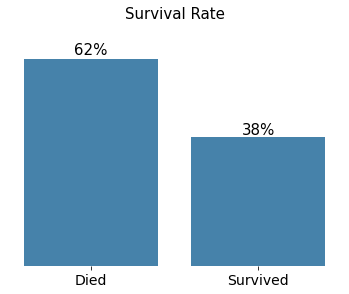

In [16]:
# Plot outcome counts.a
outcome_counts = df_train_cat['survived'].value_counts(normalize = True)

base_color = sns.color_palette()[0]
ax = sns.barplot(x=outcome_counts.index, y=outcome_counts.values, alpha=0.9, color=base_color)
ax.xaxis.label.set_size(20)
#ax.title.set_size(10)

legend_labels = ['Died', 'Survived']
_ = plt.xticks(fontsize=14, ticks=ax.get_xticks(), labels=legend_labels)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
_ = plt.yticks([])

_ = plt.title('Survival Rate', fontsize=15, pad=30)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    _ = ax.annotate(f'{height:.0%}', (x + width/2, y + height*1.02), ha='center', fontsize=15)

plt.show();


The survival statistics are as follows:


In [17]:
print(df_train_cat['survived'].value_counts())
print("\n")

#print(df_train_cat['survived'].value_counts(normalize = True).mul(100).round(1).astype(str) + '%')
#print("\n")

0    549
1    342
Name: survived, dtype: int64




We observe that 38% of passengers survived and 62% died. These statistics correspond with the narrative on survival
rate quoted in the background information on Kaggle. There it is quoted that around 32% survived and 68% died. The
sample we are working with is thus representative of the overall population, which is important to note.

We observe that the target variable contains unbalanced classes. We need to consider revisiting the unbalanced
classes at a later stage - depending on the accuracy of our models. For now, we will forge ahead.

Next we will consider class level counts for categorical variables.

#### Categorical variable overview

In [18]:
# Class level counts for categorical variables.
for variable in names_cat:
    print(df_train_cat[variable].value_counts(normalize = True).mul(100).round(1).astype(str) + '%')
    print("\n")

0    61.6%
1    38.4%
Name: survived, dtype: object


3    55.1%
1    24.2%
2    20.7%
Name: p_class, dtype: object


male      64.8%
female    35.2%
Name: sex, dtype: object


0    68.2%
1    23.5%
2     3.1%
4     2.0%
3     1.8%
8     0.8%
5     0.6%
Name: sib_sp, dtype: object


0    76.1%
1    13.2%
2     9.0%
3     0.6%
5     0.6%
4     0.4%
6     0.1%
Name: parch, dtype: object


S    72.5%
C    18.9%
Q     8.6%
Name: embarked, dtype: object




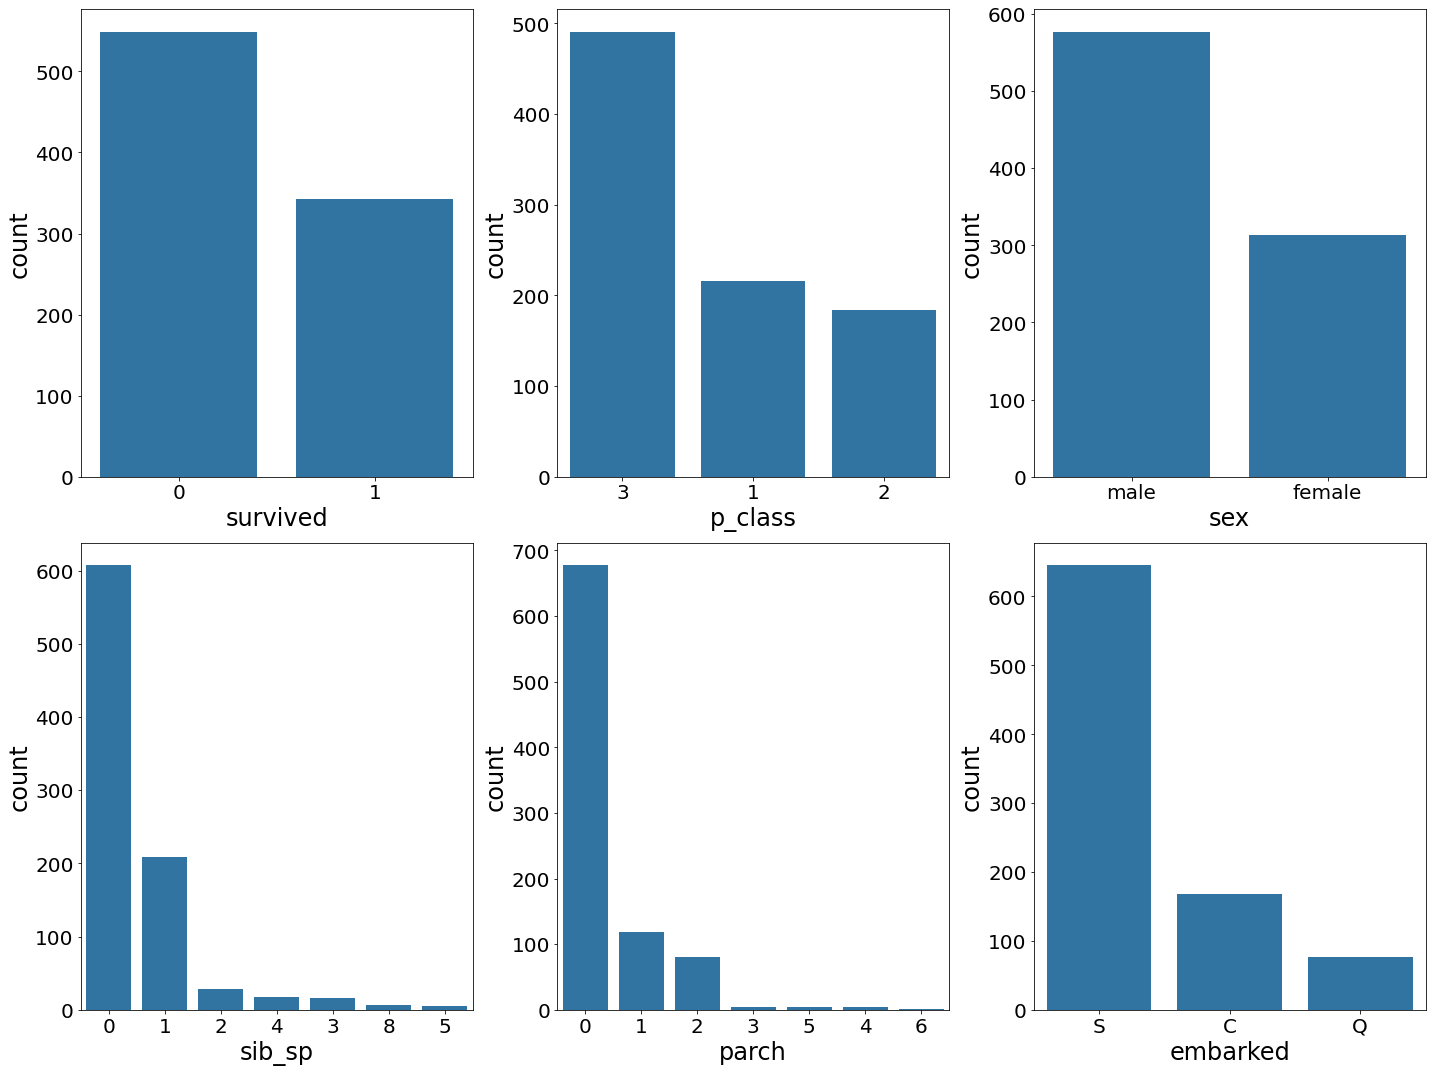

In [19]:
# Bar chart plot of categorical variables.
fig, ax = plt.subplots(2, 3, figsize=(20, 15));
base_color = sns.color_palette()[0]
for variable, subplot in zip(names_cat, ax.flatten()):
    subplot.xaxis.label.set_size(24)
    subplot.yaxis.label.set_size(24)
    subplot.tick_params('y', labelsize = 20);
    subplot.tick_params('x', labelsize = 20);
    cat_order = df_train_cat[variable].value_counts().index
    cp = sns.countplot(data = df_train_cat, x = variable, order = cat_order, ax=subplot, color=base_color)
    plt.tight_layout()

From the categorical variables we observe that there were approximately twice as many passengers in class 3 than either
class 1 or 2. We also observe that there were nearly twice as many males as females on the Titanic. We also observe
that more than two thirds of passengers did not have any siblings on board. Likewise we observe that more than two
thirds did not have a father or child on board.

It is therefore fair to say that the majority of passengers were either couples or single travellers without children
. In the case where families did travel, the majority of families had one or two children. Very few families with
more children were on board the Titanic.

We also see that more than two thirds of passengers departed from Southampton.

Many of these variables could contribute o correlation with survival at face value e.g. it stands to reason that
preference would have been given in lifeboats to women and children, and that more affluent travellers would have had
access to better lifeboats. We will however test these hypotheses in this analysis.

#### Continuous variable overview

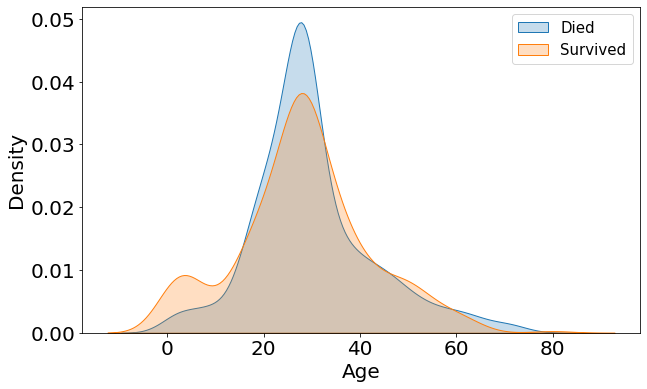

In [20]:
fig_age, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), squeeze=False)
_ = plotAge(df=df_train_con_plot, axes=axes, single_plot=True);


From the age distribution plot we can see that more children under the age of 15 survived than died in the incident. 
We can see that more individuals between the ages of 20 and 40 died than survived. We can also see that more 
individuals above the age of 80 survived compared to dying.

We can also see that the majority of individuals on the cruise were between the ages of 20 to 40. There were fewer
teenagers compared to children under 10. There were comparatively fewer elderly people on board i.e. above 60.

In [21]:
# 5 number summary.
df_train_con.describe()


,fare,age
count,891.000000,891.000000
mean,32.204208,29.361582
std,49.693429,13.019697
min,0.000000,0.420000
25%,7.910400,22.000000
50%,14.454200,28.000000
75%,31.000000,35.000000
max,512.329200,80.000000


The fare distribution is severely skewed to the right. The kurtosis of the plot is very high with most values
clustered closely around the median value of 14. There was a non-significant but relatively smaller number of fares
spread between teh values of 30 and 500.

The age distribution was as previously discussed, with a minimum of 6 months and maximum of 80 years old. The
distribution is fairly symmetrical with a slight skew to the right. There is a young child bump to the left of the
distribution.

/Users/lourens/Code/GitHub/ProjectsPrivate/kaggle_01_titanic/venvmac/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lourens/Code/GitHub/ProjectsPrivate/kaggle_01_titanic/venvmac/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


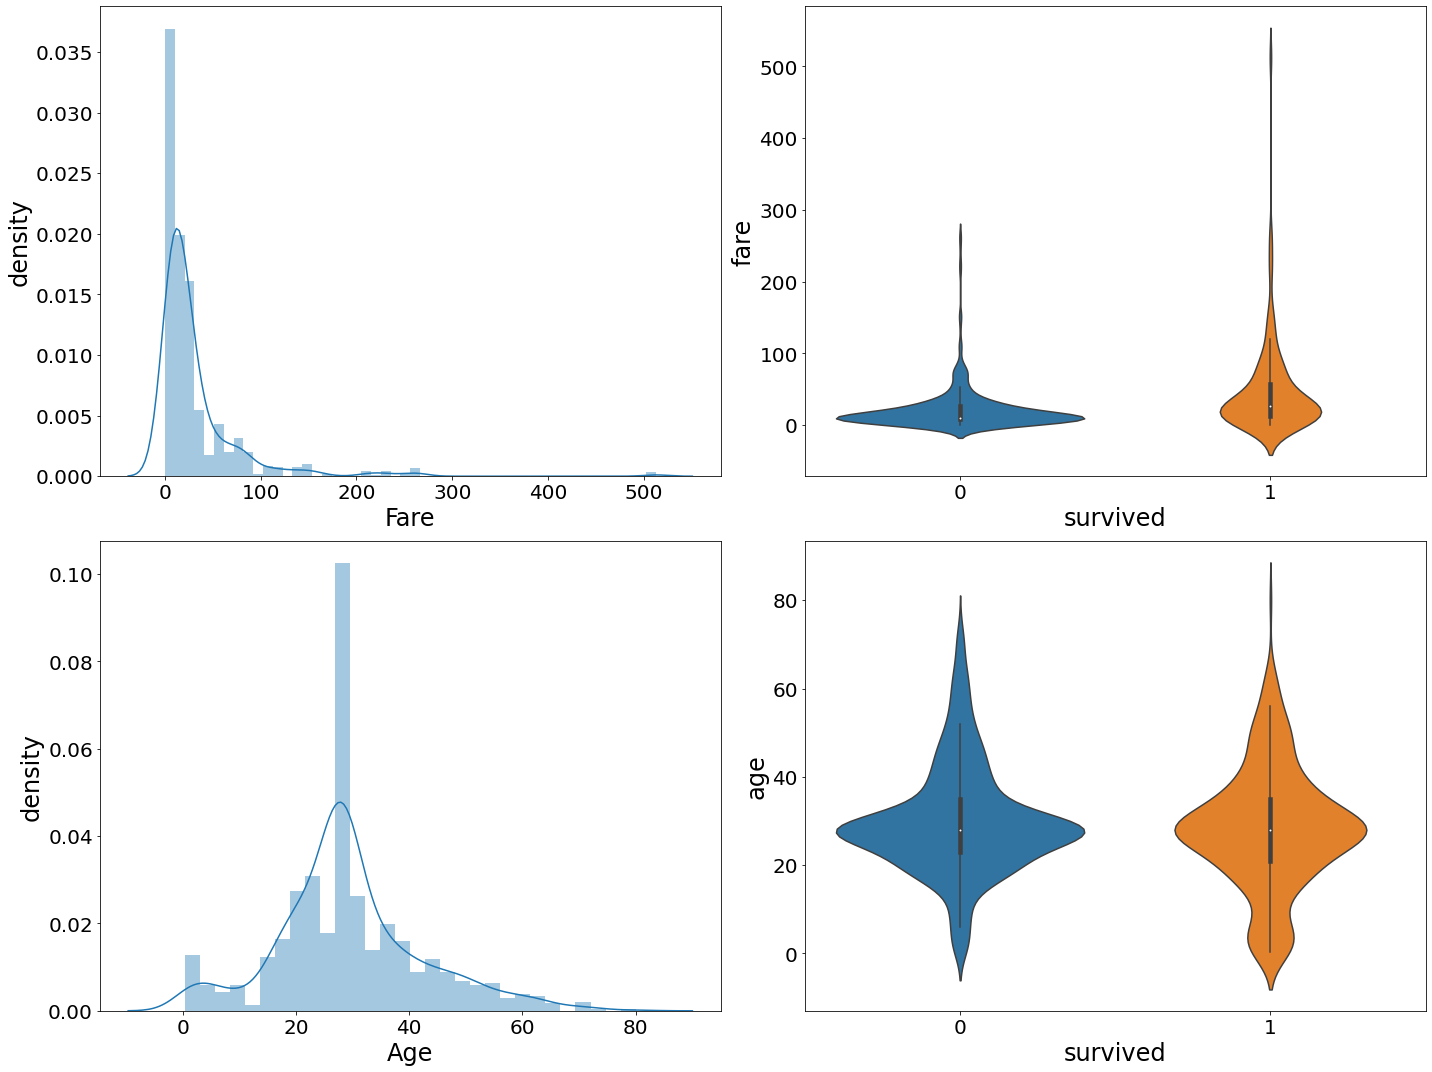

In [22]:
# Continuous density plot
fig_continuous, axes = plt.subplots(nrows=len(names_con_plot)-1, ncols=2, figsize=(20, 15))
_ = plotVar(isCategorical=False, categorical = plot_cat, continuous = plot_con, df=df_train_con_plot, axes=axes);

The violin plot for <i>fare</i> indicates that there is correlation between fare and survival as more people paying a
low fare died and chances of survival increased for higher fares, as well as lower fares close to zero (possibly for
children travelling at very low cost).

The plot for <i>age</i> indicates a similar pattern with higher survival for children below 10 and higher mortality
between ages of 20 and 40. The relative likelihood of survival increases again around 40 years of age as you go into
the older ages.


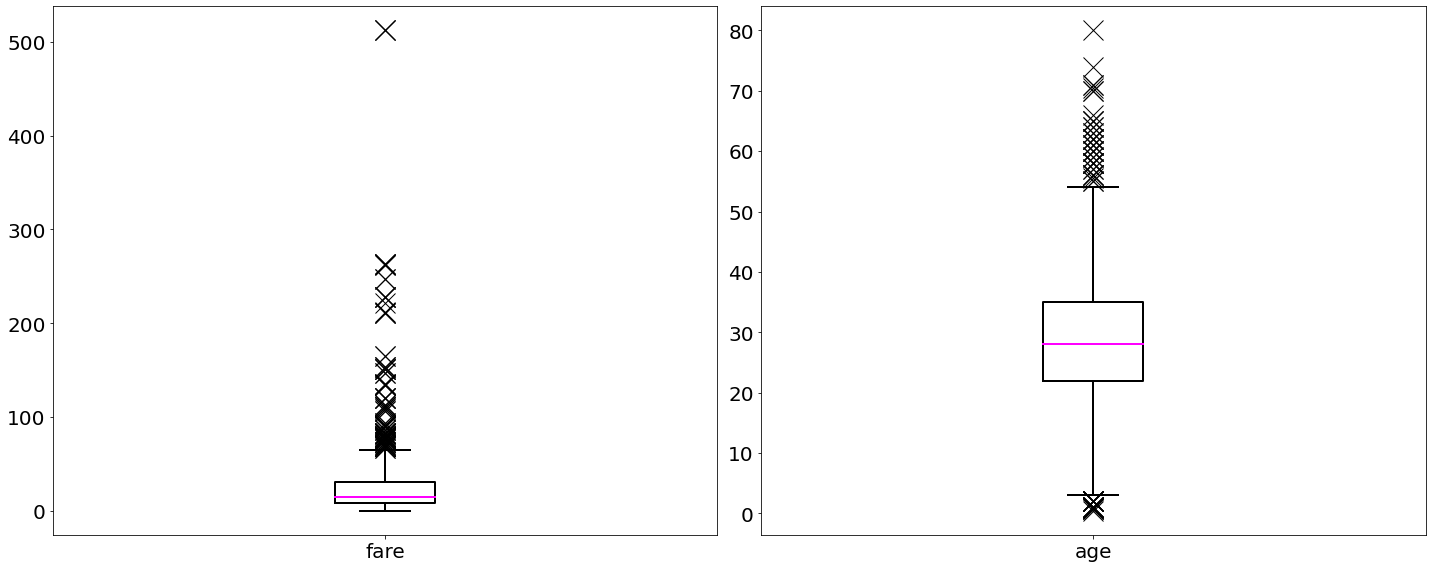

In [23]:
# Boxplot of continuous variables
medianprops = {'color': 'magenta', 'linewidth': 2}
boxprops = {'color': 'black', 'linestyle': '-', 'linewidth': 2}
whiskerprops = {'color': 'black', 'linestyle': '-', 'linewidth': 2}
capprops = {'color': 'black', 'linestyle': '-', 'linewidth': 2}
flierprops = {'color': 'black', 'marker': 'x', 'markersize': 20}

_ = df_train_con.plot(kind='box', subplots=True, figsize=(20, 8), layout=(1,2), fontsize = 20, medianprops=medianprops,
                    boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops);
_ = plt.tight_layout();
_ = plt.show();


The distributions of the <i>fare</i> and <i>age</i> variables show that fare is skewed heavily to the right, with the
median skewed to the left of the distribution as expected. The values in the final quintile are spread over wide area
with quite a few outliers. This distribution is heavy tailed, as can be expected of many financial distributions.

The <i>age</i> distribution is fairly symmetrical, with a few outliers to the right, but nothing out of the ordinary.
Most of the values are bundled symmetrically around the median of 28, which is quite a young age for the average
traveller.

<div class="alert alert-block alert-info">
<b>Transform variables</b>
</div>

We will now build the following models as previously discussed:

 1. Logistic regression
 2. Multi-layer Perceptron (MLP)
 3. Decision Tree
 4. Random Forest

We start by splitting the response and the features for the training set as previously created. We will be using this
dataset for all our models from here onwards. We also perform minor transformations such as encoding the <i>sex</i>
variable for test and training sets. We also One Hot Encode the <i>embarked</i> variable. We drop one of the
categories for embarked to avoid multi-collinearity.

In [24]:
# Group response values to form binary response
y = df_train.loc[:, 'survived']

# Split data into features (X) and response (y)
X = df_train.loc[:, ('p_class', 'sex', 'age', 'sib_sp', 'parch', 'fare', 'embarked')]
df_test = df_test.loc[:, ('p_class', 'sex', 'age', 'sib_sp', 'parch', 'fare', 'embarked')]

# Put the response y into an array
y = np.ravel(y)

# Transform sex variable
X['sex'] = X['sex'].apply(lambda x: 1 if x == 'female' else 0)
#X.head()

# Same transformation for test set.
df_test['sex'] = df_test['sex'].apply(lambda x: 1 if x == 'female' else 0)
#df_test.head()

# Transform embarked variable
ohe = OneHotEncoder(categories='auto', drop='first')
Xd = ohe.fit_transform(X.embarked.values.reshape(-1, 1)).toarray()
df_ohe = pd.DataFrame(Xd, columns = ohe.get_feature_names())
#print(df_ohe)

X = pd.concat([X.loc[:, ['p_class', 'sex', 'age', 'sib_sp', 'parch', 'fare']], df_ohe], axis=1)
#X.head()

# Transform embarked variable for test set
ohe2 = OneHotEncoder(categories='auto', drop='first')
Xd2 = ohe2.fit_transform(df_test.embarked.values.reshape(-1, 1)).toarray()
df_ohe2 = pd.DataFrame(Xd2, columns = ohe.get_feature_names())
#print(df_ohe2)

df_test = pd.concat([df_test.loc[:, ['p_class', 'sex', 'age', 'sib_sp', 'parch', 'fare']], df_ohe2], axis=1)
#df_test.head()
#print(df_test.isnull().sum())

#### Split and scale the data

We now split the data into training and test sets according to a 75/ 25% split. We then scale the data by using the
Standard Scaler to account for the differences between continuous and categorical variable scales of measurement.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
#print('Percentage holdout data: {}%'.format(round(100*(len(X_test)/len(X)),0)))

# Scale data
scaler = StandardScaler()

# Fit on training data set
scaler.fit(X_train)
X_train = scaler.transform(X_train)

# Apply to test data (training)
X_test = scaler.transform(X_test)

# Apply to final test data
df_test = scaler.transform(df_test)


StandardScaler()

<div class="alert alert-block alert-info">
<b>Build models</b>
</div>

We can now start building our first model.
We now build and test a naive logistic regression model - without any transformations or optimisations.

#### Naive Logistic Regression

AUC: 0.8642086330935251


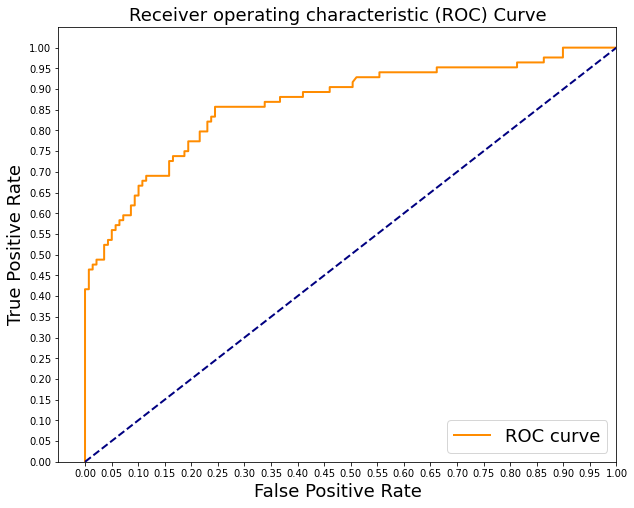

In [26]:
# Initial model
logreg = LogisticRegression(max_iter=2000000, fit_intercept = False)

# Probability scores for test set
y_score_init = logreg.fit(X_train, y_train).decision_function(X_test)

# False positive Rate and true positive rate
fpr_roc, tpr_roc, thresholds = roc_curve(y_test, y_score_init)

plot_roc_curve(fpr = fpr_roc, tpr = tpr_roc)

Normalized confusion matrix

accuracy:			0.77  
precision:			0.832 
sensitivity:			0.677

specificity:			0.863 
negative predictive value:	0.727

false positive rate:		0.137  
false negative rate:		0.323 
false discovery rate:		0.168


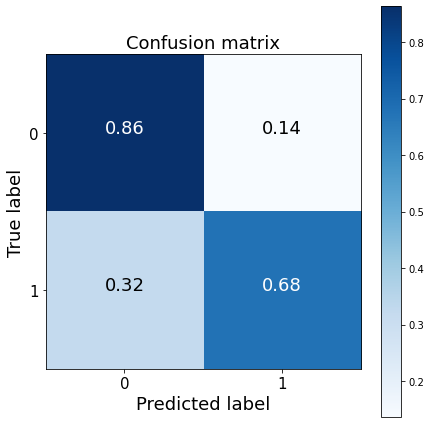

In [27]:
y_pred = logreg.predict(X_test)
# Accuracy before model parameter optimisation
cnf_matrix = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True)

As can be seen from the accuracy measurements the baseline model performs very well. A C-statistic of 86% on data that
has only been scaled without any transformation is an excellent result. This result is somewhat surprising given our
high level EDA outcomes which showed only slight correlation between age and fare and survival rate.

Based on this result it is evident that there must be stronger correlation for at least a few of the
categorical variables. Our more in-depth analysis will hopefully shed more light on this!

We will now investigate this correlation further, but first, we will build a few more models to further investigate
the raw strength of signal in the data.

Next we build a simple Multi Layer Perceptron using scikit-learn to see if it does any better than the Logistic
Regression.

#### Naive MLP

In [28]:
# Fit and check MSE before regularisation
reg = MLPClassifier(max_iter=50000, solver="adam", activation="tanh", hidden_layer_sizes=(5, 5), random_state=1)
reg.fit(X_train, y_train)

# Predict
y_pred = reg.predict(X_test)

# Accuracy before model parameter optimisation
accuracy_score(y_pred,y_test)

MLPClassifier(activation='tanh', hidden_layer_sizes=(5, 5), max_iter=50000,
              random_state=1)

0.8161434977578476

We now optimise the NN architecture.

In [29]:
# Optimise numbers of nodes on both layers
validation_scores = {}
print("Nodes |Validation")
print("      | score")

for hidden_layer_size in [(i,j) for i in range(2,6) for j in range(2,6)]:

    reg = MLPClassifier(max_iter=1000000, hidden_layer_sizes=hidden_layer_size, random_state=1)

    score = cross_val_score(estimator=reg, X=X_train, y=y_train, cv=2)
    validation_scores[hidden_layer_size] = score.mean()
    print(hidden_layer_size, ": %0.5f" % validation_scores[hidden_layer_size])

Nodes |Validation
      | score
(2, 2) : 0.80689
(2, 3) : 0.75000
(2, 4) : 0.79790
(2, 5) : 0.82186
(3, 2) : 0.78593
(3, 3) : 0.77246
(3, 4) : 0.79341
(3, 5) : 0.79042
(4, 2) : 0.79790
(4, 3) : 0.80988
(4, 4) : 0.80240
(4, 5) : 0.80539
(5, 2) : 0.79192
(5, 3) : 0.76796
(5, 4) : 0.80389
(5, 5) : 0.79790


In [30]:
# Check scores
print("The highest validation score is: %0.4f" % max(validation_scores.values()))
optimal_hidden_layer_size = [name for name, score in validation_scores.items()
                              if score==max(validation_scores.values())][0]
print("This corresponds to nodes", optimal_hidden_layer_size )


The highest validation score is: 0.8219
This corresponds to nodes (2, 5)


Now we optimise neural network regularisation parameter

 alpha  |  Accuracy
0.13534 |  0.7964071856287425
0.22313 |  0.7964071856287425
0.36788 |  0.7934131736526946
0.60653 |  0.7964071856287425
1.00000 |  0.7919161676646707
1.64872 |  0.7964071856287425
2.71828 |  0.7934131736526946
4.48169 |  0.7994011976047904
7.38906 |  0.8083832335329342
12.18249 |  0.8023952095808383
20.08554 |  0.6137724550898204
33.11545 |  0.6137724550898204


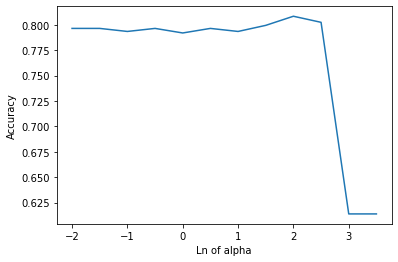

In [31]:
# Select range over which to find regularisation parameter - exponential used for even distribution of values
reg_par = [np.e**n for n in np.arange(-2,4,0.5)]

validation_scores = {}
print(" alpha  |  Accuracy")
for param in reg_par:
    reg = MLPClassifier(max_iter=1000000, solver="adam", activation="tanh", hidden_layer_sizes=optimal_hidden_layer_size, alpha=param,
                        random_state=1)
    score = cross_val_score(estimator=reg, X=X_train, y=y_train, cv=2, scoring="accuracy")
    validation_scores[param] = score.mean()
    print("%0.5f |  %s" % (param, score.mean()))

# Plot the accuracy function against regularisation parameter
plt.plot([np.log(i) for i in validation_scores.keys()], list(validation_scores.values()));
plt.xlabel("Ln of alpha");
plt.ylabel("Accuracy");

The highest cross-validation accuracy score and hence the value to use for the `alpha` parameter is as follows.

In [32]:
max_score = ([np.log(name) for name, score in validation_scores.items() if score==max(validation_scores.values())][0])
# Find lowest value.
print("The highest accuracy score is: %s" % (max(validation_scores.values())))
print("This corresponds to regularisation parameter e**%s" % max_score)

The highest accuracy score is: 0.8083832335329342
This corresponds to regularisation parameter e**2.0


#### MSE after regularisation

In [33]:
# Fit data with the best parameter
reg = MLPClassifier(max_iter=1000000, solver="adam", activation="tanh", hidden_layer_sizes=optimal_hidden_layer_size,
                    alpha=np.e**(2), random_state=1)

reg.fit(X_train, y_train)

# Predict
y_pred = reg.predict(X_test)

# Accuracy after model parameter optimisation
accuracy_score(y_pred,y_test)

MLPClassifier(activation='tanh', alpha=7.3890560989306495,
              hidden_layer_sizes=(2, 5), max_iter=1000000, random_state=1)

0.7937219730941704

#### Accuracy analysis

AUC: 0.7709403905447071
Normalized confusion matrix

accuracy:			0.783  
precision:			0.803 
sensitivity:			0.75

specificity:			0.816 
negative predictive value:	0.766

false positive rate:		0.184  
false negative rate:		0.25 
false discovery rate:		0.197


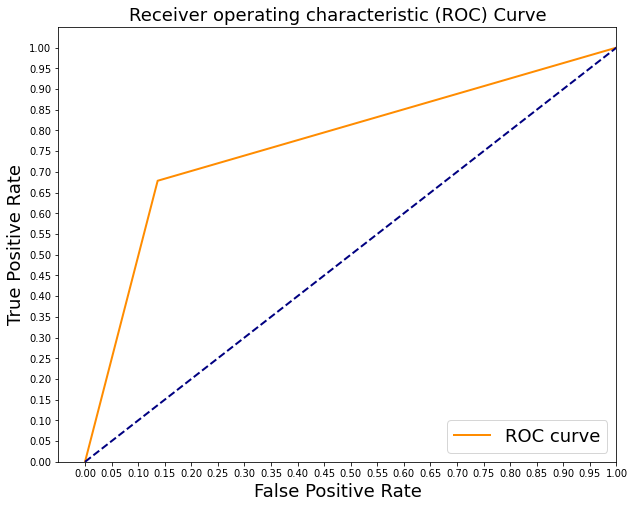

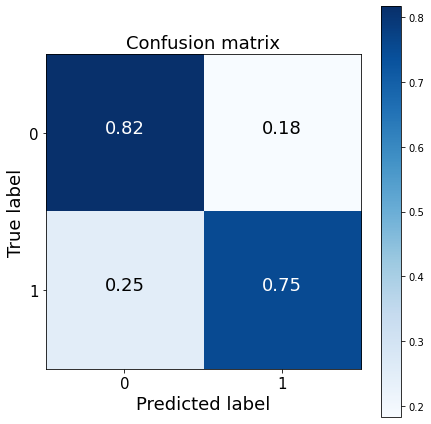

In [34]:
# False positive Rate and true positive rate
fpr_roc, tpr_roc, thresholds = roc_curve(y_test, y_pred)
plot_roc_curve(fpr = fpr_roc, tpr = tpr_roc)

cnf_matrix = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True)



In [35]:
#accuracy = round(accuracy_score(y_pred=y_pred, y_true=y_test), 3)
#precision = round(precision_score(y_pred=y_pred, y_true=y_test), 3)
#recall = round(recall_score(y_pred=y_pred, y_true=y_test), 3)
#cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
#
#fp_label='false positive'
#fp = cm[0][1]
#fn_label='false negative'
#fn = cm[1][0]
#tp_label='true positive'
#tp = cm[1][1]
#tn_label='true negative'
#tn = cm[0][0]
#
#tpr_label = 'sensitivity'
#tpr = round(tp/(tp+fn),3)
#tnr_label = 'specificity'
#tnr = round(tn/(tn+fp),3)
#ppv_label = 'precision'
#ppv = round(tp/(tp+fp),3)
#npv_label = 'npv'
#npv = round(tn/(tn+fn),3)
#fpr_label = 'fpr'
#fpr = round(fp/(fp+tn),3)
#fnr_label = 'fnr'
#fnr = round(fn/(tp+fn),3)
#fdr_label = 'fdr'
#fdr = round(fp/(tp+fp),3)
#
#print('\naccuracy:\t\t\t{}  \nprecision:\t\t\t{} \nrecall:\t\t\t\t{}'.format(accuracy, precision, recall))
#print('\nsensitivity:\t\t\t{}  \nspecificity:\t\t\t{} \nnegative predictive value:\t{}'.format(tpr, tnr, npv))
#print('\nfalse positive rate:\t\t{}  \nfalse negative rate:\t\t{} \nfalse discovery rate:\t\t{}'.format(fpr, fnr, fdr))
#

#### Naive Decision Tree


7
Feature:    p_class	Score:	0.13526
Feature:        sex	Score:	0.49185
Feature:        age	Score:	0.11971
Feature:     sib_sp	Score:	0.07073
Feature:      parch	Score:	0.00574
Feature:       fare	Score:	0.15124
Feature:       x0_Q	Score:	0.01817
Feature:       x0_S	Score:	0.00729


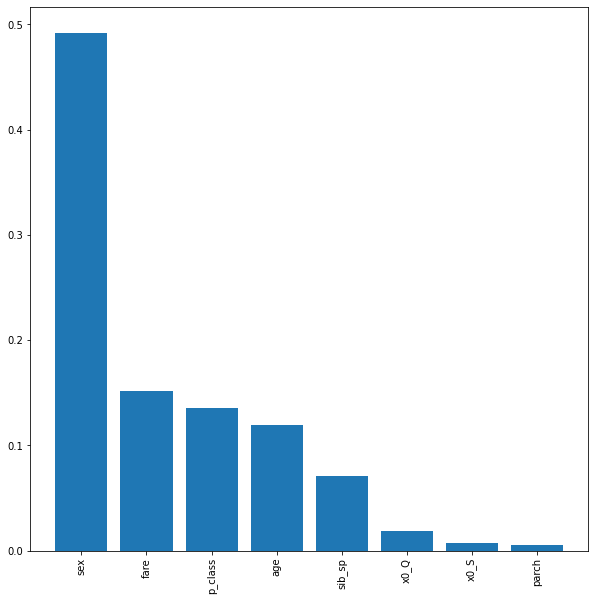

In [36]:
# Fit a Decision Tree to data
samples = [sample for sample in range(1,30)]
validation_scores = []
for sample in samples:
    classifier1 = DecisionTreeClassifier(random_state=1, min_samples_leaf=sample)
    score = cross_val_score(estimator=classifier1, X=X_train, y=y_train, cv=5)
    validation_scores.append(score.mean())

# Obtain the minimum leaf samples with the highest validation score
samples_optimum = samples[validation_scores.index(max(validation_scores))]
print(samples_optimum)

classifier2 = DecisionTreeClassifier(random_state=0, min_samples_leaf=samples_optimum)
classifier2.fit(X_train, y_train)

importances = np.array(classifier2.feature_importances_)
feature_list = np.array(X.columns)

# summarize feature importance
for i,v in enumerate(importances):
	print('Feature: %10s\tScore:\t%.5f' % (feature_list[i],v))
# plot feature importance
sorted_ID=np.array(np.argsort(importances)[::-1])
plt.figure(figsize=[10,10])
plt.xticks(rotation='vertical')
_ = plt.bar(feature_list[sorted_ID], importances[sorted_ID]);
plt.show();

#### Accuracy analysis

AUC: 0.7709403905447071
Normalized confusion matrix

accuracy:			0.783  
precision:			0.803 
sensitivity:			0.75

specificity:			0.816 
negative predictive value:	0.766

false positive rate:		0.184  
false negative rate:		0.25 
false discovery rate:		0.197


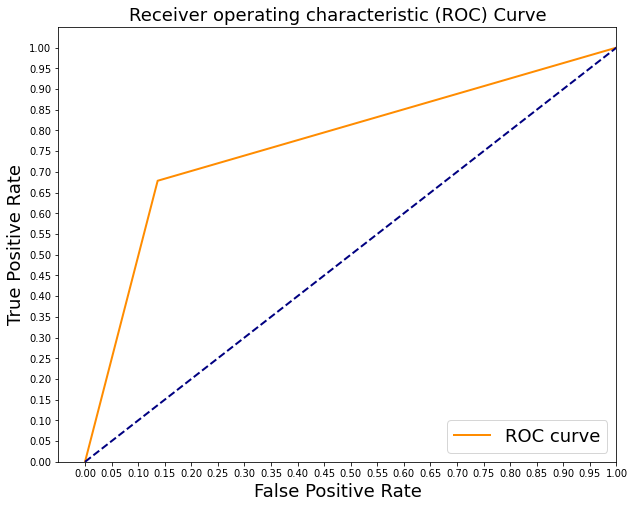

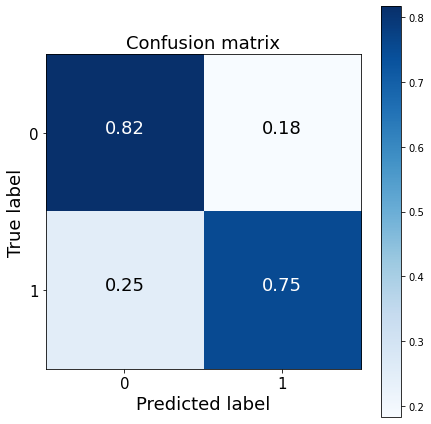

In [37]:
# False positive Rate and true positive rate
fpr_roc, tpr_roc, thresholds = roc_curve(y_test, y_pred)
plot_roc_curve(fpr = fpr_roc, tpr = tpr_roc)

cnf_matrix = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True)


#### Naive Random Forest

In [38]:
# Not very convincing results, next we will look at random forests and logistic regression
# as means to detect feature importance.
rand_forest = RandomForestClassifier(criterion= 'gini', random_state=0)
rand_forest.fit(X_train, y_train)

# Probability scores for test set
y_pred = rand_forest.predict(X_test)

accuracy_score(y_pred,y_test)

RandomForestClassifier(random_state=0)

0.8385650224215246

In [39]:
# Final prediction - MLP
#y_pred = reg.predict(df_test)

# Final prediction - Random Forest
#y_pred = rand_forest.predict(X_test)

#### Accuracy analysis

AUC: 0.8186879068174032
Normalized confusion matrix

accuracy:			0.833  
precision:			0.845 
sensitivity:			0.816

specificity:			0.85 
negative predictive value:	0.822

false positive rate:		0.15  
false negative rate:		0.184 
false discovery rate:		0.155


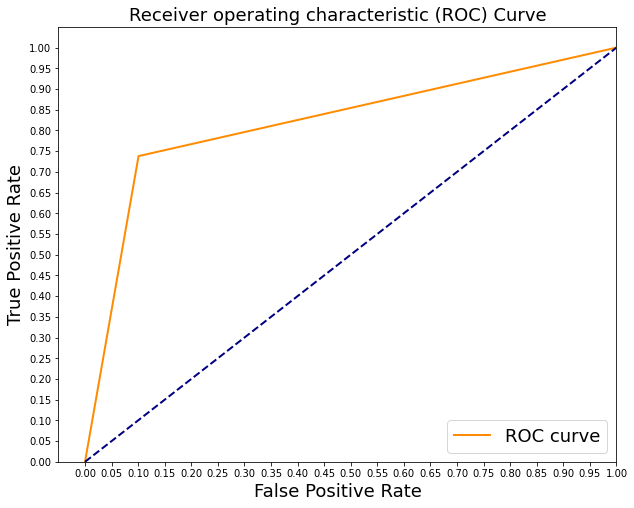

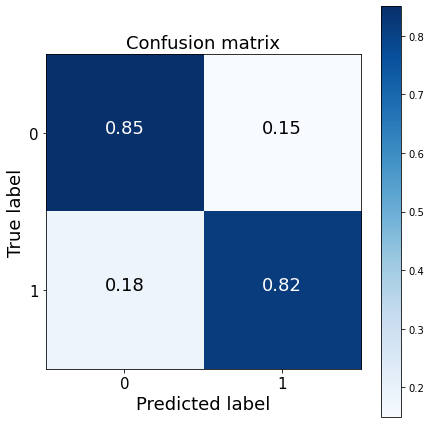

In [40]:
# False positive Rate and true positive rate
fpr_roc, tpr_roc, thresholds = roc_curve(y_test, y_pred)
plot_roc_curve(fpr = fpr_roc, tpr = tpr_roc)

cnf_matrix = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True)



<div class="alert alert-block alert-info">
<b>Conclusion</b>
</div>


We can conclude that there is a strong signal in the data with regards to correlation with survival rate.
Counter-intuitively, the Logistic Regression proved to be the best model scoring approximately 86% for the
C-Statistic. The Random Forest classifier is second with 84% for the C-Statistic. We would have expected the Random
Forest to outperform the Logistic Regression given all the categorical variables. The strong correlation between age,
 fare and survival probably outweighed the categorical variable influence on survival rate. We expect the Random
 Forest to improve once we add names and cabins back into the mix. Also, in the name of speed we used scaled values
 for the Random Forest and it might do better on the original data. We will need to test this in the next notebook.

All in all, this was an insightful analysis. We found that the few variables we have are very strong predictors for
survival. In a real world setting further analysis is probably not necessary, as the gains from over-engineering
variables for a model which does not have much practical value is probably not worthwhile.

This is however an educational exercise and hence we will go ahead and try to squeeze more accuracy and insight out
of the remaining variables. Focusing more on the insight than accuracy, as at this point the model is probably
accurate enough for any practical application that might exist (which there obviously doesn't!).

On to the next notebook!

In [41]:
#Prepare submission code
#my_submission = pd.DataFrame({'PassengerId': df_orig.passenger_id, 'Survived': y_pred})
# you could use any filename. We choose submission here
#my_submission.to_csv('submission.csv', index=False)